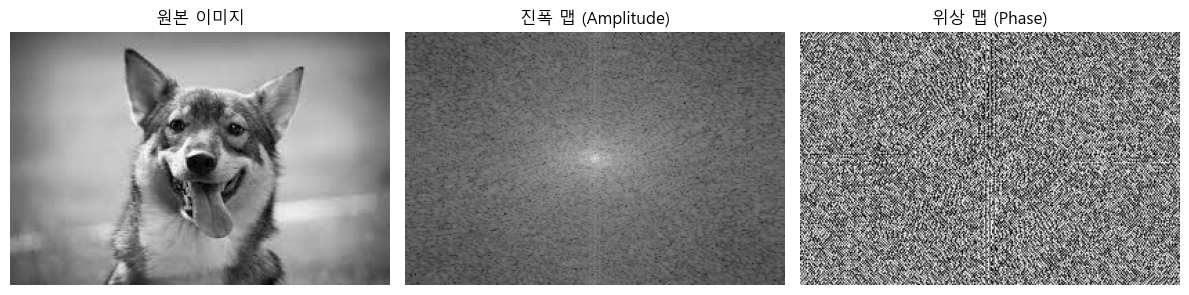

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy.fftpack import fft2, fftshift

# 한글 사용하기 위한 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

image1 = Image.open('dog.jpg').convert('L')
image2 = Image.open('please.jpg').convert('L')

# 2D FFT 수행
fft_image1 = fft2(image1)

# 주파수 스펙트럼 시프트
fft_shifted1 = fftshift(fft_image1)

# 진폭(amplitude) 계산 (복소수 크기)
amplitude1 = np.abs(fft_shifted1)

# 위상(phase) 계산 (복소수의 각도)
phase1 = np.angle(fft_shifted1)

# 진폭과 위상 맵 시각화
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(image1, cmap='gray')
plt.title('원본 이미지')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.log1p(amplitude1), cmap='gray')
plt.title('진폭 맵 (Amplitude)')
plt.axis('off')

plt.subplot(133)
plt.imshow(phase1, cmap='gray')
plt.title('위상 맵 (Phase)')
plt.axis('off')

plt.tight_layout()
plt.show()


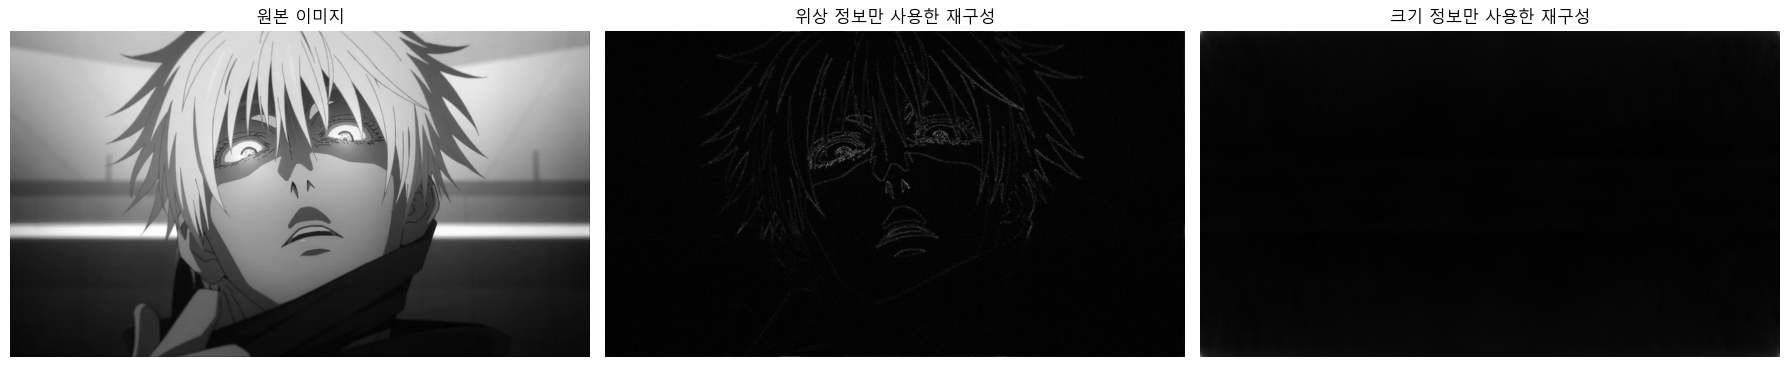

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from skimage.color import rgb2gray
from skimage.io import imread

# 이미지 로드 및 회색조 변환
image = imread('please.jpg')
gray_image = rgb2gray(image)

# 2D FFT 수행
fft_image = fft2(gray_image)
fft_shifted = fftshift(fft_image)

# 진폭과 위상 계산
magnitude = np.abs(fft_shifted)
phase = np.angle(fft_shifted)

# 위상만을 사용한 재구성 (크기 정보를 무시)
reconstructed_phase_only = np.abs(ifft2(ifftshift(np.exp(1j * phase))))

# 크기만을 사용한 재구성 (위상 정보를 무시)
reconstructed_magnitude_only = np.abs(ifft2(ifftshift(magnitude)))

# 원본 이미지, 위상 재구성 이미지, 크기 재구성 이미지 시각화
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(gray_image, cmap='gray')
plt.title('원본 이미지')
plt.axis('off')

plt.subplot(132)
plt.imshow(reconstructed_phase_only, cmap='gray')
plt.title('위상 정보만 사용한 재구성')
plt.axis('off')

plt.subplot(133)
plt.imshow(reconstructed_magnitude_only, cmap='gray')
plt.title('크기 정보만 사용한 재구성')
plt.axis('off')

plt.tight_layout()
plt.show()


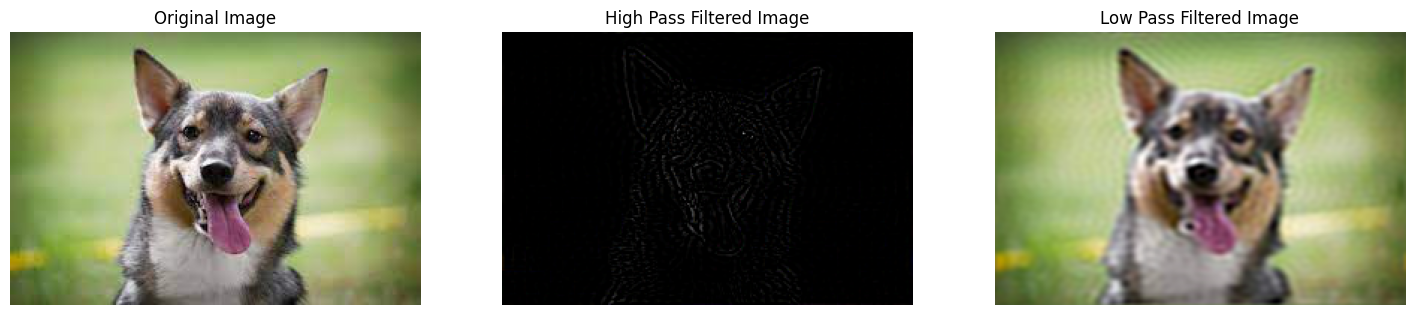

In [186]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 로드
image_path = 'dog.jpg'
image = Image.open(image_path).convert('RGB')  # 이미지를 컬러로 로드

# 이미지 텐서로 변환
transform = transforms.ToTensor()
x = transform(image).unsqueeze(0)  # 배치 차원 추가

# FFT 적용
x_fft = torch.fft.fft2(x, dim=(2, 3))
x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

# 마스크 생성
rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
center_row, center_col = rows // 2, cols // 2
cutoff_frequency = min(rows, cols) // 5

high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)

y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

high_pass_mask[:, :, dist <= cutoff_frequency] = 0
low_pass_mask[:, :, dist <= cutoff_frequency] = 1

# 고주파 및 저주파 필터링
high_pass = x_fft_shifted * high_pass_mask
low_pass = x_fft_shifted * low_pass_mask

# IFFT 적용
high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real

# 텐서를 이미지로 변환
high_pass_ifft = torch.clamp(high_pass_ifft, 0, 1)  # 값 범위를 [0, 1]로 클램핑
low_pass_ifft = torch.clamp(low_pass_ifft, 0, 1)    # 값 범위를 [0, 1]로 클램핑

high_pass_image = transforms.ToPILImage()(high_pass_ifft.squeeze(0))

low_pass_image = transforms.ToPILImage()(low_pass_ifft.squeeze(0))

high_pass_mask_image = transforms.ToPILImage()(low_pass_ifft.squeeze(0))

x_fft_shifted_image = transforms.ToPILImage()(abs(x_fft_shifted).squeeze(0))
# 결과 시각화
plt.figure(figsize=(18, 6))

# 원본 이미지 시각화
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# 고주파 필터링 결과 시각화
plt.subplot(1, 3, 2)
plt.title("High Pass Filtered Image")
plt.imshow(high_pass_image)
plt.axis('off')

# 저주파 필터링 결과 시각화
plt.subplot(1, 3, 3)
plt.title("Low Pass Filtered Image")
plt.imshow(low_pass_image)
plt.axis('off')

plt.show()


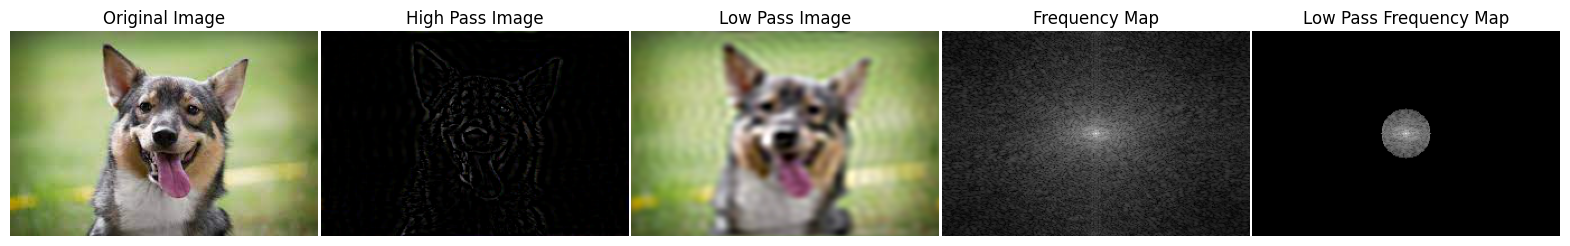

In [210]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 이미지 로드
image_path = 'dog.jpg'
image = Image.open(image_path).convert('RGB')  # 이미지를 컬러로 로드

# 이미지 텐서로 변환
transform = transforms.ToTensor()
x = transform(image).unsqueeze(0)  # 배치 차원 추가

# FFT 적용
x_fft = torch.fft.fft2(x, dim=(2, 3))
x_fft_shifted = torch.fft.fftshift(x_fft, dim=(2, 3))

# 마스크 생성
rows, cols = x_fft_shifted.shape[2], x_fft_shifted.shape[3]
center_row, center_col = rows // 2, cols // 2
cutoff_frequency = min(rows, cols) // 8

high_pass_mask = torch.ones_like(x_fft_shifted, dtype=torch.float32)
low_pass_mask = torch.zeros_like(x_fft_shifted, dtype=torch.float32)

y, x = torch.meshgrid(torch.arange(rows), torch.arange(cols), indexing='ij')
dist = torch.sqrt((x - center_col)**2 + (y - center_row)**2)

high_pass_mask[:, :, dist <= cutoff_frequency] = 0
low_pass_mask[:, :, dist <= cutoff_frequency] = 1

# 고주파 및 저주파 필터링
high_pass = x_fft_shifted * high_pass_mask
low_pass = x_fft_shifted * low_pass_mask

# IFFT 적용
high_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(high_pass, dim=(2, 3)), dim=(2, 3)).real
low_pass_ifft = torch.fft.ifft2(torch.fft.ifftshift(low_pass, dim=(2, 3)), dim=(2, 3)).real

# 텐서를 이미지로 변환
high_pass_ifft = torch.clamp(high_pass_ifft, 0, 1)  # 값 범위를 [0, 1]로 클램핑
low_pass_ifft = torch.clamp(low_pass_ifft, 0, 1)    # 값 범위를 [0, 1]로 클램핑

high_pass_image = transforms.ToPILImage()(high_pass_ifft.squeeze(0))
low_pass_image = transforms.ToPILImage()(low_pass_ifft.squeeze(0))

# low_pass 주파수 맵 절댓값 (Amplitude) 계산 및 시각화
low_pass_amplitude = torch.log(1 + torch.abs(low_pass))
low_pass_amplitude = low_pass_amplitude.squeeze(0).numpy()
low_pass_amplitude = np.sum(low_pass_amplitude, axis=0)  # 채널 합산 (RGB 채널)

# FFT 절댓값 (주파수 맵) 시각화
amplitude_spectrum = torch.log(1 + torch.abs(x_fft_shifted))
amplitude_spectrum = amplitude_spectrum.squeeze(0).numpy()
amplitude_spectrum = np.sum(amplitude_spectrum, axis=0)  # 채널 합산 (RGB 채널)

# 결과 시각화
plt.figure(figsize=(20, 8))

# 원본 이미지 시각화
plt.subplot(1, 5, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

# 고주파 성분 이미지 시각화
plt.subplot(1, 5, 2)
plt.title("High Pass Image")
plt.imshow(high_pass_image)
plt.axis('off')

# 저주파 성분 이미지 시각화
plt.subplot(1, 5, 3)
plt.title("Low Pass Image")
plt.imshow(low_pass_image)
plt.axis('off')

# 전체 주파수 맵 시각화
plt.subplot(1, 5, 4)
plt.title("Frequency Map")
plt.imshow(amplitude_spectrum, cmap='gray')
plt.axis('off')

# 저주파 주파수 맵 시각화
plt.subplot(1, 5, 5)
plt.title("Low Pass Frequency Map")
plt.imshow(low_pass_amplitude, cmap='gray')
plt.axis('off')

plt.subplots_adjust(wspace=0.01) 

plt.show()
